# Tracking sensAI experiments

In this notebook we will demonstrate how to use sensAI's tracking utilities with evaluators
and parameter sweeps. Several backends are supported and it is very easy to write a new custom adapter
for a different tracking framework. In this notebook we will use [trains](https://github.com/allegroai/trains)
as tracking backend. After running it, you can access the results on the trains
[demoserver](https://demoapp.trains.allegro.ai/) (if you have not provided your own trains config)

In [1]:
# Note - this cell should be executed only once per session
%load_ext autoreload
%autoreload 2

import sys, os

# in order to get the config, it is not part of the library
os.chdir("..")
sys.path.append(os.path.abspath("."))

In [2]:
import geopandas as gp

from sensai.hyperopt import GridSearch
from sklearn.cluster import DBSCAN
import logging

from sensai.clustering.coordinate_clustering import SKLearnCoordinateClustering
from sensai.evaluation.evaluator_clustering import ClusteringModelSupervisedEvaluator
from sensai.evaluation.clustering_ground_truth import PolygonAnnotatedCoordinates
from sensai.tracking.trains_tracking import TrackedTrainsExperiment

import matplotlib.pyplot as plt

from config import get_config

logging.basicConfig(level=logging.INFO)
c = get_config(reload=True)

INFO:config.__Configuration:Reading configuration from /home/runner/work/sensAI/sensAI/config.json


### Evaluators

The main entrypoint to reproducible experiments is the evaluator api. We will use clustering evaluation for
demonstration purposes. We load the data and create a SupervisedClusteringEvaluator, see
[intro to evaluation](Clustering%20Evaluation.ipynb) for more details.

[comment]: <> (TODO - use some VectorModel with an sklearn dataset instead, move the notebook to sensAI repo)

In [3]:
# loading the data and ground truth labels
sampleFile = c.datafile_path("sample", stage=c.RAW) # this can point to a directory or a shp/geojson file
sampleGeoDF = gp.read_file(sampleFile)
groundTruthClusters = PolygonAnnotatedCoordinates(sampleGeoDF, c.datafile_path("sample", stage=c.GROUND_TRUTH))

In [4]:
# creating the evaluator
groundTruthCoordinates, groundTruthLabels = groundTruthClusters.getCoordinatesLabels()
supervisedEvaluator = ClusteringModelSupervisedEvaluator(groundTruthCoordinates, trueLabels=groundTruthLabels)

### Setup tracking

Now comes the new part - we create a tracking experiment and set it in the evaluator

In [5]:
experiment = TrackedTrainsExperiment(projectName="Demos", taskName="notebook_experiment")
supervisedEvaluator.setTrackedExperiment(experiment)

TRAINS Task: created new task id=94d710d211a6491198e4bafb9689a09e


TRAINS results page: https://demoapp.trains.allegro.ai/projects/0cf1f690e09d43678d394b45f8a74232/experiments/94d710d211a6491198e4bafb9689a09e/output/log


As simple as that! Whenever we perform an evaluation, the results will be tracked. Depending on
the backend and the particular implementation of the experiment, the code and other information
like images will get tracked as well. We will demonstrated the tracking of the evaluation of a dbscan.

In [6]:
boundedDbscan = SKLearnCoordinateClustering(DBSCAN(eps=150, min_samples=20), minClusterSize=100)
supervisedEvaluator.computeMetrics(boundedDbscan)

INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 57 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.15s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 1.51s


TRAINS Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


{'VMeasureScore': 0.661727751698087,
 'FowlkesMallowsScore': 0.27503572733470316,
 'AdjustedRandScore': 0.17987036763356976,
 'AdjustedMutualInfoScore': 0.6497595011750351,
 'numClusters': 57,
 'averageClusterSize': 197.94736842105263,
 'clusterSizeStd': 252.18173765930052,
 'maxClusterSize': 1983,
 'minClusterSize': 100,
 'medianClusterSize': 132.0,
 'noiseClusterSize': 67499}

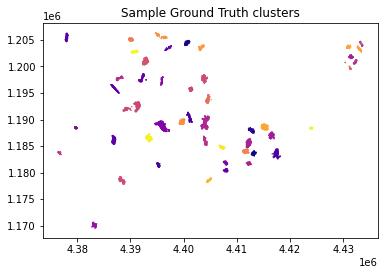

In [7]:
# plots are tracked automatically on creation.
# Note that one should use fig.show instead of plt.show

fig, ax = plt.subplots(figsize=[6, 8])
ax.set_title("Sample Ground Truth clusters")
groundTruthClusters.plot(includeNoise=False, markersize=0.2, cmap="plasma", ax=ax)
fig.show()

INFO:sensai.clustering.base.clustering:Processed 0% of clusters


INFO:sensai.clustering.base.clustering:Processed 5% of clusters


INFO:sensai.clustering.base.clustering:Processed 10% of clusters


INFO:sensai.clustering.base.clustering:Processed 15% of clusters


INFO:sensai.util.tracking:Finished execution of toGeoDF in 2.57s


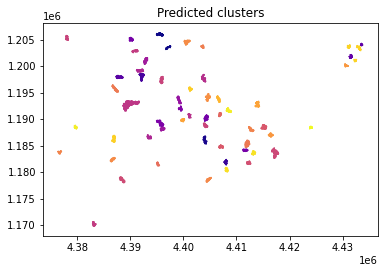

In [8]:
fig, ax = plt.subplots(figsize=[6, 8])
ax.set_title("Predicted clusters")
boundedDbscan.plot(includeNoise=False, markersize=0.2, cmap="plasma", ax=ax, figsize=10)
fig.show()


In [9]:
# We can also add the summaries df to the experiment through explicit tracking

logger  = supervisedEvaluator.trackedExperiment.logger

logger.report_table(title="Clusters Summaries", series="pandas DataFrame", iteration=0,
                    table_plot=boundedDbscan.summaryDF().sort_values("numMembers"))

INFO:sensai.clustering.base.clustering:Processed 0% of clusters


INFO:sensai.clustering.base.clustering:Processed 5% of clusters


INFO:sensai.clustering.base.clustering:Processed 10% of clusters


INFO:sensai.clustering.base.clustering:Processed 15% of clusters


The same mechanism works in the hyperopts module. The experiment can be set for GridSearch
or simulated annealing. One can also set the experiment in the evaluator that is passed to
the hyperopt objects and use that one for tracking instead. Here an example


In [10]:
# because of how trains works and because we are using it in jupyter, we need to manually close the existing task
# even though the docu says, with reuse_last_task_id=False a new task would be created...
# this step is unnecessary if one has one experiment per script execution
# we also unset the tracked experiment in the evaluator and prepare a new one for the grid search

supervisedEvaluator.trackedExperiment.task.close()
supervisedEvaluator.unsetTrackedExperiment()


def dbscanFactory(**kwargs):
    return SKLearnCoordinateClustering(DBSCAN(**kwargs), minClusterSize=100)

parameterOptions = {
    "min_samples": [10, 20],
    "eps": [50, 150]
}

dbscanGridSearch = GridSearch(dbscanFactory, parameterOptions,
                              csvResultsPath=os.path.join(c.temp, "dbscanGridSearchCsv"))
gridExperiment = TrackedTrainsExperiment(projectName="Demos", taskName="notebook_grid_search")
dbscanGridSearch.setTrackedExperiment(gridExperiment)

INFO:config:Configured directory temp='/home/runner/work/sensAI/sensAI/temp' not found; will create it


INFO:sensai.hyperopt:Created GridSearch object for 4 parameter combinations


TRAINS Task: created new task id=1b3b9f510c3440b3add778e1b3368832


TRAINS results page: https://demoapp.trains.allegro.ai/projects/0cf1f690e09d43678d394b45f8a74232/experiments/1b3b9f510c3440b3add778e1b3368832/output/log


In [11]:
searchResults = dbscanGridSearch.run(supervisedEvaluator, sortColumnName="numClusters")

INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 10, 'eps': 50}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 12 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.06s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 1.19s


INFO:sensai.hyperopt:Updated grid search result:
  numClusters  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore  AdjustedMutualInfoScore  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples eps
0          12        0.36016             0.185506           0.011638                 0.352041          263.833333      314.595728           1288            101              150.0            75616  SKLearnCoordinateClustering          10  50


INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 10, 'eps': 150}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


TRAINS Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 125 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.35s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 1.69s


INFO:sensai.hyperopt:Updated grid search result:
  numClusters  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore  AdjustedMutualInfoScore  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0          12       0.360160             0.185506           0.011638                 0.352041          263.833333      314.595728           1288            101              150.0            75616  SKLearnCoordinateClustering          10   50
1         125       0.352457             0.116221           0.005487                 0.332641          279.784000      306.998830           2135            100              169.0            43809  SKLearnCoordinateClustering          10  150


INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 20, 'eps': 50}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 5 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.02s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 1.06s


INFO:sensai.hyperopt:Updated grid search result:
  numClusters  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore  AdjustedMutualInfoScore  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0           5       0.207358             0.165565           0.003231                 0.202292          253.200000      163.416523            568            102              210.0            77516  SKLearnCoordinateClustering          20   50
1          12       0.360160             0.185506           0.011638                 0.352041          263.833333      314.595728           1288            101              150.0            75616  SKLearnCoordinateClustering          10   50
2         125       0.352457             0.116221           0.005487                 0.332641          279.784000      306.998830           2135            100              169.0            43809  SKLearnCoordinateClustering 

INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 20, 'eps': 150}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 57 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.09s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 1.39s


INFO:sensai.hyperopt:Updated grid search result:
  numClusters  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore  AdjustedMutualInfoScore  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0           5       0.207358             0.165565           0.003231                 0.202292          253.200000      163.416523            568            102              210.0            77516  SKLearnCoordinateClustering          20   50
1          12       0.360160             0.185506           0.011638                 0.352041          263.833333      314.595728           1288            101              150.0            75616  SKLearnCoordinateClustering          10   50
2          57       0.661728             0.275036           0.179870                 0.649760          197.947368      252.181738           1983            100              132.0            67499  SKLearnCoordinateClustering 

In [12]:
# unfortunately, the trains experiment interface is at conflict with the grid search
# the most pragmatic solution is to simply attach the dataframe to the experiment and to use it for further evaluation

dbscanGridSearch.trackedExperiment.logger.report_table(title="Results", series="pandas DataFrame", iteration=0,
                    table_plot=searchResults)
